## Improving Water Consumption Management in Barcelona through Data Quality Enhancement and Prediction Models
#### **TFG 2023-2024**
#### **Author: Edith Ruiz Macià**

### Analysis of dataset Dataset1_v2.csv

### **About the Notebook**

The aim of this notebook (.ipynb) is to analyze and modify the dataset dataset1_v2.csv provided by Aigües de Barcelona in order to improve the quality of the data and learn its insights through its visualization.

#### ***How to execute the code***
This is a Python Notebook, so the code should be run either cell by cell or by running all the notebook at once. At the beginning, review and make sure the paths to all datasets are correct for your folders distribution in order for everything to run smoothly.

#### ***Libraries and packages used in the project***
Here is a brief explanation of the imported libraries:

1. **pandas:** Library for data manipulation and analysis. It is used to work with data structures such as DataFrames.
2. **matplotlib.pyplot:** Used to create graphs and visualizations.
3. **matplotlib.dates:** Used to create graphs and visualizations.
4. **numpy:** Fundamental library for numerical computation.
5. **seaborn:** Data visualization library based on Matplotlib. It provides a high-level interface for drawing attractive statistical graphs.
6. **sklearn.preprocessing:** Provides functions to preprocess data before fitting a model.
7. **sklearn.model_selection:** Provides tools to split data sets into training and test subsets for a model.
8. **sklearn.metrics:** Contains metrics for evaluating models.
9. **sklearn.feature_selection:** Library to select the best features for training a model.
10. **sklearn.linear_model**: Contains implementations of linear regression models.
11. **sklearn.ensemble:** Contains implementations of ensemble models such as Random Forest.
12. **xgboost:** Library to implement Gradient Boosting models.
13. **sklearn.neighbors:** Library to implement K-Nearest Neighbors models.
14. **sklearn.svm:** Library to implement Support Vector Machine models.
15. **shap:** Library used to compute the shap values of a model and model explainability.


In [115]:
# In case you are working in google colab you can mount your google drive account here
# from google.colab import drive
# drive.mount('/content/drive')

## 0. Importing datasets and libraries

In [116]:
!pip install shap

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [117]:
# Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import pickle
import shap

In [118]:
# Change your path of the data if necessary
dataset1 = 'C:/Users/edith/Desktop/TFG/Datasets/Aigües de Barcelona/Sets-de-dades/dataset1_v2.csv'
dataset1 = pd.read_csv(dataset1)
dataset1.head()

,Secció Censal/Sección censal/Census section,Districte/Distrito/District,Codi postal/Código postal/Postcode,Municipi/Municipio/Municipality,Data/Fecha/Date,Ús/Uso/Use,Nombre de comptadors/Número de contadores/Number of meters,Consum acumulat (L/dia)/Consumo acumulado(L/día)/Accumulated Consumption (L/day)
0,NaN,NaN,8001,BARCELONA,2019-01-01,Domèstic/Doméstico/Domestic,4,819.0
1,NaN,NaN,8001,BARCELONA,2019-01-01,Industrial/Industrial/Industrial,3,209.0
2,NaN,NaN,8001,BARCELONA,2019-01-02,Domèstic/Doméstico/Domestic,4,1052.0
3,NaN,NaN,8001,BARCELONA,2019-01-02,Industrial/Industrial/Industrial,3,565.0
4,NaN,NaN,8001,BARCELONA,2019-01-03,Domèstic/Doméstico/Domestic,4,827.0


## 1. Exploratory Data Analysis

As a starting point, we need to explore the data. We analyze the summary of descriptive statistics and plots in order to detect the corresponding anomalies and subsequently process them correctly.

In [119]:
dataset1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4820790 entries, 0 to 4820789
Data columns (total 8 columns):
 #   Column                                                                            Dtype  
---  ------                                                                            -----  
 0   Secció Censal/Sección censal/Census section                                       float64
 1   Districte/Distrito/District                                                       float64
 2   Codi postal/Código postal/Postcode                                                int64  
 3   Municipi/Municipio/Municipality                                                   object 
 4   Data/Fecha/Date                                                                   object 
 5   Ús/Uso/Use                                                                        object 
 6   Nombre de comptadors/Número de contadores/Number of meters                        int64  
 7   Consum acumulat (L/dia)/Cons

In [120]:
dataset1.describe()

,Secció Censal/Sección censal/Census section,Districte/Distrito/District,Codi postal/Código postal/Postcode,Nombre de comptadors/Número de contadores/Number of meters,Consum acumulat (L/dia)/Consumo acumulado(L/día)/Accumulated Consumption (L/day)
count,4.684807e+06,4.684807e+06,4.820790e+06,4.820790e+06,4.820790e+06
mean,8.047516e+08,4.611122e+00,8.220219e+03,1.479731e+02,3.856883e+04
std,6.270135e+06,2.959483e+00,3.695504e+02,1.955371e+02,5.058181e+05
min,8.015090e+08,1.000000e+00,8.001000e+03,2.000000e+00,-4.152945e+08
25%,8.019030e+08,2.000000e+00,8.014000e+03,1.100000e+01,3.440000e+03
50%,8.019061e+08,4.000000e+00,8.025000e+03,4.000000e+01,1.329800e+04
75%,8.019101e+08,7.000000e+00,8.041000e+03,2.650000e+02,6.773300e+04
max,8.301020e+08,1.000000e+01,8.980000e+03,1.254000e+03,4.194848e+08


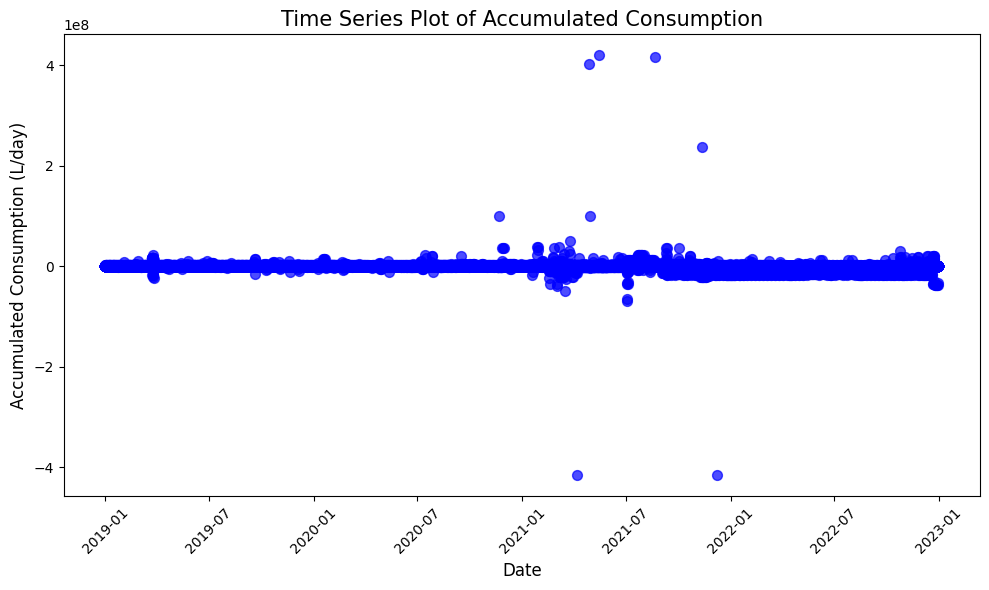

In [121]:
# Accumulated Consumption over Time
dataset1['Data/Fecha/Date'] = pd.to_datetime(dataset1['Data/Fecha/Date'])
plt.figure(figsize=(10, 6))
plt.scatter(dataset1['Data/Fecha/Date'], dataset1['Consum acumulat (L/dia)/Consumo acumulado(L/día)/Accumulated Consumption (L/day)'], color='blue', marker='o', s=50, alpha=0.7, label='Data Points')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Accumulated Consumption (L/day)', fontsize=12)
plt.title('Time Series Plot of Accumulated Consumption', fontsize=15)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

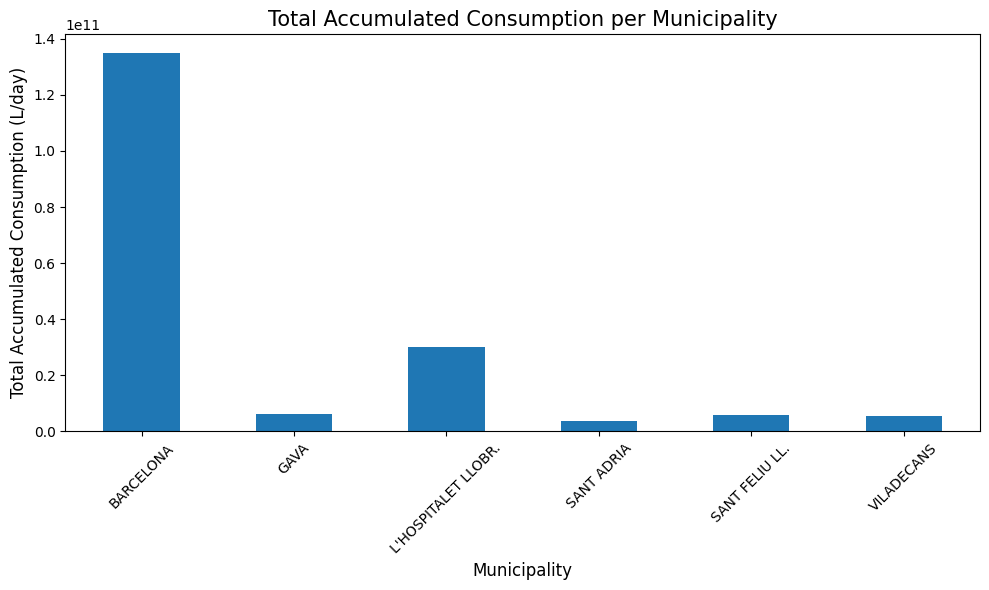

In [122]:
# Aggregate total consumption for each municipality
total_consumption_per_municipality = dataset1.groupby('Municipi/Municipio/Municipality')['Consum acumulat (L/dia)/Consumo acumulado(L/día)/Accumulated Consumption (L/day)'].sum()
total_consumption_per_municipality.plot(kind='bar', figsize=(10,6))
plt.xlabel('Municipality', fontsize=12)
plt.ylabel('Total Accumulated Consumption (L/day)', fontsize=12)
plt.title('Total Accumulated Consumption per Municipality', fontsize=15)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [123]:
print("Poscodes of Barcelona:")
print(dataset1[dataset1['Municipi/Municipio/Municipality'] == 'BARCELONA']["Codi postal/Código postal/Postcode"].unique())

Poscodes of Barcelona:
[8001 8002 8003 8004 8005 8006 8007 8008 8009 8010 8011 8012 8013 8014
 8015 8016 8017 8018 8019 8020 8021 8022 8023 8024 8025 8026 8027 8028
 8029 8030 8031 8032 8033 8034 8035 8036 8037 8038 8039 8040 8041 8042]


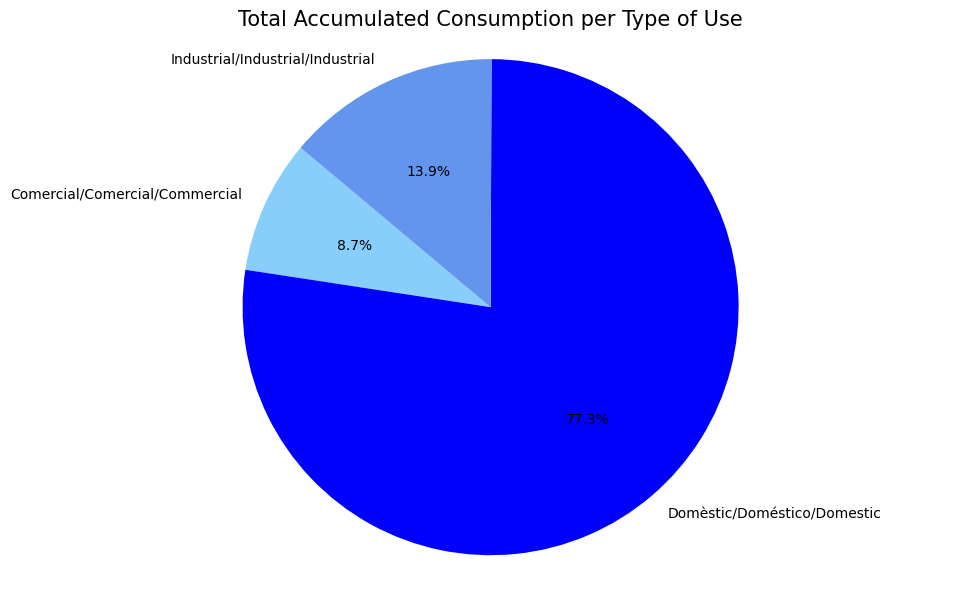

In [124]:
# Aggregate total consumption for each type of use
total_consumption_per_use = dataset1.groupby('Ús/Uso/Use')['Consum acumulat (L/dia)/Consumo acumulado(L/día)/Accumulated Consumption (L/day)'].sum()
plt.figure(figsize=(10, 6))
total_consumption_per_use.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['lightskyblue', 'blue', 'cornflowerblue'])
plt.title('Total Accumulated Consumption per Type of Use', fontsize=15)
plt.ylabel(None)
plt.tight_layout()
plt.axis('equal')
plt.show()

**Insights:**
- Negative consumption values are considered as incorrect values for the Cumulative Consumption (L/day) column. Consumption has to be positive.
- The number of meters ('Number of meters') varies greatly, with some locations having just one meter and others up to 1254 meters.
- In the scatter plot we can clearly see outliers that will be removed later on.
- Most of the consumption is accumulated in the Municipality of Barcelona and it's of Domestic use.

## 2. Data Preprocessing

##### **2.1. Data Transformation**

In [125]:
# Rename dataset1_v2 columns
new_column_names = {
    'Secció Censal/Sección censal/Census section': 'Census section',
    'Districte/Distrito/District': 'District',
    'Codi postal/Código postal/Postcode': 'Postcode',
    'Municipi/Municipio/Municipality': 'Municipality',
    'Data/Fecha/Date': 'Date',
    'Ús/Uso/Use': 'Use',
    'Nombre de comptadors/Número de contadores/Number of meters': 'Number of meters',
    'Consum acumulat (L/dia)/Consumo acumulado(L/día)/Accumulated Consumption (L/day)': 'Accumulated Consumption (L/day)'
}

dataset1.rename(columns=new_column_names, inplace=True)

In [126]:
# Randomly sample 700000 data points
sampled_indices = np.random.choice(len(dataset1), size=700000, replace=False)
sampled_data = dataset1.iloc[sampled_indices]

# Scatter Plot for Accumulated Consumption vs Number of Meters without negatives
plt.figure(figsize=(10, 6))
plt.scatter(sampled_data['Number of meters'], sampled_data['Accumulated Consumption (L/day)'], color='blue', marker='o', s=50, alpha=0.7, label='Data Points')
plt.title('Accumulated Consumption vs Number of Meters without negatives', fontsize=15)
plt.xlabel('Number of Meters', fontsize=12)
plt.ylabel('Accumulated Consumption (L/day)', fontsize=12)
plt.ylim(0, 100000)

# Calculate the trend line
x = sampled_data['Number of meters']
y = sampled_data['Accumulated Consumption (L/day)']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red')

plt.show()

OverflowError: Exceeded cell block limit in Agg.  Please set the value of rcParams['agg.path.chunksize'], (currently 0) to be greater than 100 or increase the path simplification threshold(rcParams['path.simplify_threshold'] = 0.111111111111 by default and path.simplify_threshold = 0.111111111111 on the input).

<Figure size 1000x600 with 1 Axes>

We cannot assure that consumption is not normalized, but according to the plots above it does not look like it therefore, they have to be normalized. We will divide the Accumulated Consumption by the Number of Meters in order to obtain the Accumulated Consumption for a single Meter.

In [127]:
# Normalization of Accumulated Consumption (L/day) by Number of meters
dataset1['Normalized Accumulated Consumption (L/day)'] = round(dataset1['Accumulated Consumption (L/day)'] / dataset1['Number of meters'], 3)
dataset1.head()

,Census section,District,Postcode,Municipality,Date,Use,Number of meters,Accumulated Consumption (L/day),Normalized Accumulated Consumption (L/day)
0,NaN,NaN,8001,BARCELONA,2019-01-01,Domèstic/Doméstico/Domestic,4,819.0,204.750
1,NaN,NaN,8001,BARCELONA,2019-01-01,Industrial/Industrial/Industrial,3,209.0,69.667
2,NaN,NaN,8001,BARCELONA,2019-01-02,Domèstic/Doméstico/Domestic,4,1052.0,263.000
3,NaN,NaN,8001,BARCELONA,2019-01-02,Industrial/Industrial/Industrial,3,565.0,188.333
4,NaN,NaN,8001,BARCELONA,2019-01-03,Domèstic/Doméstico/Domestic,4,827.0,206.750


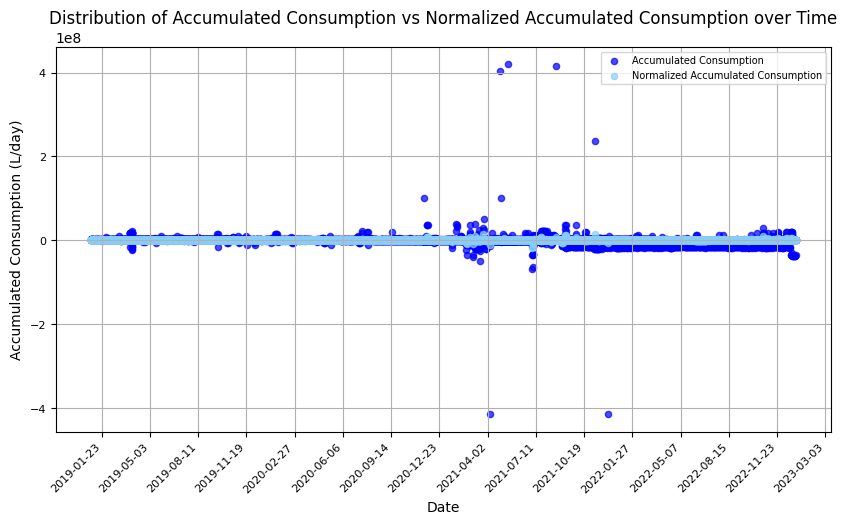

In [128]:
# Distribution of normalized vs non normalized
plt.figure(figsize=(10, 5))
plt.scatter(dataset1["Date"], dataset1["Accumulated Consumption (L/day)"], color='blue',  marker='o', s=20, alpha=0.7, label='Accumulated Consumption')
plt.scatter(dataset1["Date"], dataset1["Normalized Accumulated Consumption (L/day)"], color='lightskyblue',  marker='o', s=20, alpha=0.7, label='Normalized Accumulated Consumption')
plt.title("Distribution of Accumulated Consumption vs Normalized Accumulated Consumption over Time", fontsize=12)
plt.xlabel("Date", fontsize=10)
plt.ylabel("Accumulated Consumption (L/day)", fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)
plt.legend(fontsize=7)
tick_frequency = 100
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=tick_frequency))
plt.show()

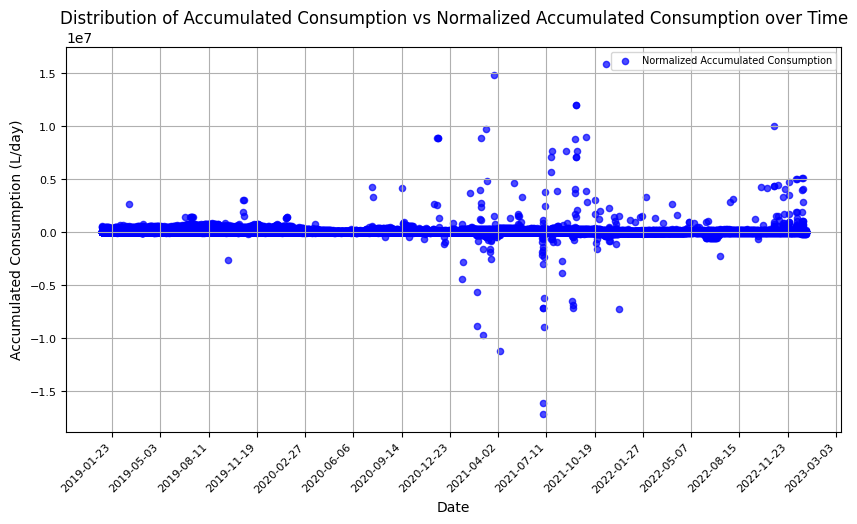

In [129]:
plt.figure(figsize=(10, 5))
plt.scatter(dataset1["Date"], dataset1["Normalized Accumulated Consumption (L/day)"], color='blue',  marker='o', s=20, alpha=0.7, label='Normalized Accumulated Consumption')
plt.title("Distribution of Accumulated Consumption vs Normalized Accumulated Consumption over Time", fontsize=12)
plt.xlabel("Date", fontsize=10)
plt.ylabel("Accumulated Consumption (L/day)", fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)
plt.legend(fontsize=7)
tick_frequency = 100
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=tick_frequency))
plt.show()

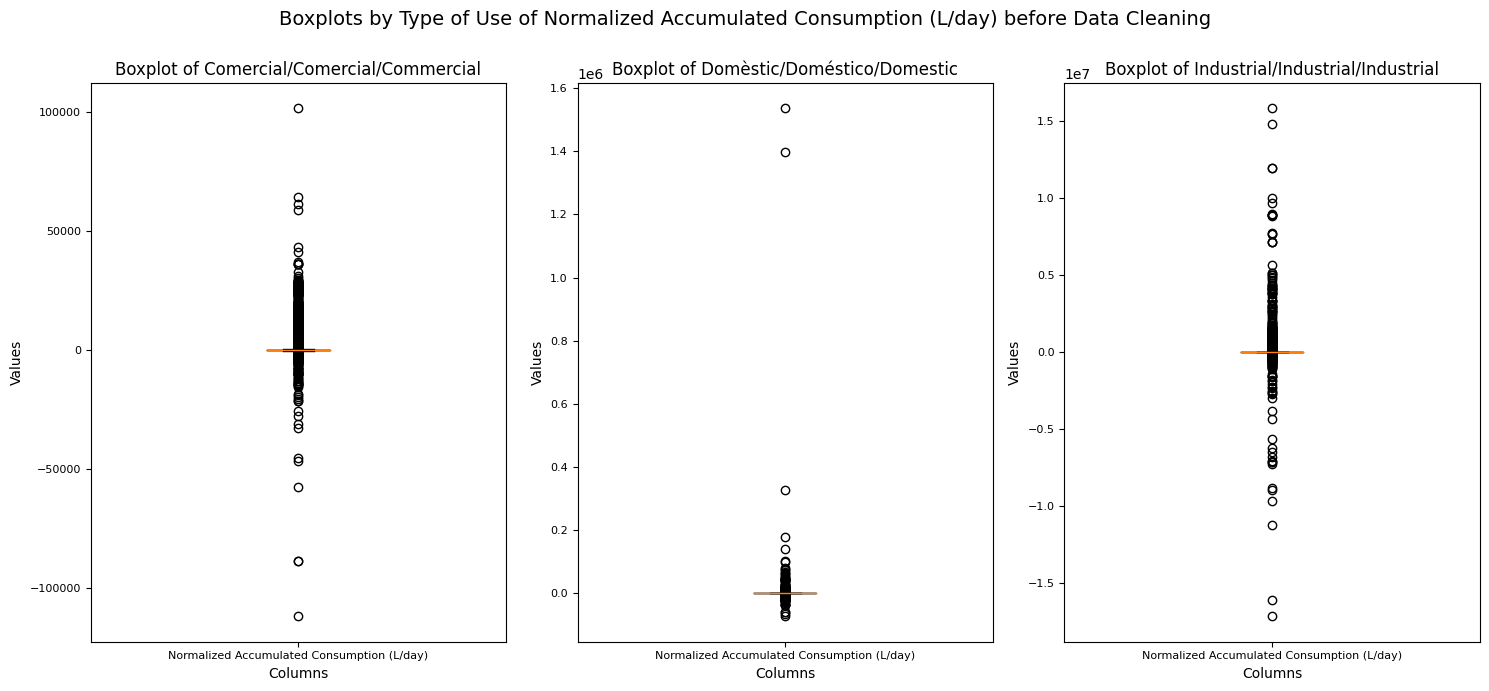

In [130]:
dataset1_box = dataset1.dropna(subset = ['District'])
dataset1_box = dataset1_box.dropna(subset = ['Census section'])

use_cases = ['Domèstic/Doméstico/Domestic', 'Comercial/Comercial/Commercial', 'Industrial/Industrial/Industrial']
num_plots = len(use_cases)
num_columns = 3
num_rows = int(np.ceil(num_plots / num_columns))

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 7))
axes = axes.flatten()

for i, use_case in enumerate(use_cases):
    iteration_dataset = dataset1_box[dataset1_box['Use'] == use_case].copy()
    columns_to_plot = ['Normalized Accumulated Consumption (L/day)']
    axes[i].boxplot([iteration_dataset[col] for col in columns_to_plot], labels=columns_to_plot)
    axes[i].set_title(f'Boxplot of {use_case}', fontsize=12)
    axes[i].set_xlabel('Columns', fontsize=10)
    axes[i].set_ylabel('Values', fontsize=10)
    axes[i].tick_params(axis='x', labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)

# Hide any unused subplots if the number of use cases is not a multiple of num_columns
for j in range(i + 1, num_rows * num_columns):
    fig.delaxes(axes[j])
    
fig.suptitle('Boxplots by Type of Use of Normalized Accumulated Consumption (L/day) before Data Cleaning', fontsize=14)
plt.tight_layout()
plt.show()

In [131]:
dataset1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4820790 entries, 0 to 4820789
Data columns (total 9 columns):
 #   Column                                      Dtype         
---  ------                                      -----         
 0   Census section                              float64       
 1   District                                    float64       
 2   Postcode                                    int64         
 3   Municipality                                object        
 4   Date                                        datetime64[ns]
 5   Use                                         object        
 6   Number of meters                            int64         
 7   Accumulated Consumption (L/day)             float64       
 8   Normalized Accumulated Consumption (L/day)  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 331.0+ MB


##### **2.2. Null Values**

In [132]:
# Null values per column
columns_dataset1 = dataset1.columns
for column in columns_dataset1:
  print("Column:", column, "- Null values: ", dataset1[column].isnull().sum())

Column: Census section - Null values:  135983
Column: District - Null values:  135983
Column: Postcode - Null values:  0
Column: Municipality - Null values:  0
Column: Date - Null values:  0
Column: Use - Null values:  0
Column: Number of meters - Null values:  0
Column: Accumulated Consumption (L/day) - Null values:  0
Column: Normalized Accumulated Consumption (L/day) - Null values:  0


##### **2.3. Wrong Values**

Now we want to identify the erroneous values in our data. We consider as wrong values the negative consumptions. We will store those values for later analysis.

In [133]:
# We identify negative values in Normalized Accumulated Consumption (L/day)
num_negative_consum_rows = len(dataset1[dataset1['Normalized Accumulated Consumption (L/day)'] < 0])
print("Negative in 'Normalized Accumulated Consumption (L/day)' in the dataset:", num_negative_consum_rows)

Negative in 'Normalized Accumulated Consumption (L/day)' in the dataset: 6222


In [134]:
# Copy the negative values into the anomalies dataset for later analysis
anomalies = dataset1[dataset1['Normalized Accumulated Consumption (L/day)'] < 0].copy()
anomalies.head()

,Census section,District,Postcode,Municipality,Date,Use,Number of meters,Accumulated Consumption (L/day),Normalized Accumulated Consumption (L/day)
3054,NaN,NaN,8001,BARCELONA,2022-04-16,Domèstic/Doméstico/Domestic,46,-12426.0,-270.130
7332,NaN,NaN,8002,BARCELONA,2022-10-06,Comercial/Comercial/Commercial,6,-330.0,-55.000
9096,NaN,NaN,8003,BARCELONA,2020-06-05,Domèstic/Doméstico/Domestic,84,-574231.0,-6836.083
10056,NaN,NaN,8003,BARCELONA,2021-05-02,Comercial/Comercial/Commercial,5,-1.0,-0.200
20198,NaN,NaN,8006,BARCELONA,2021-08-10,Industrial/Industrial/Industrial,3,-1.0,-0.333


In [135]:
# Replace negative values in Normalized Accumulated Consumption (L/day) by null
dataset1_1 = dataset1.copy()
dataset1_1.loc[dataset1_1['Normalized Accumulated Consumption (L/day)'] < 0, 'Normalized Accumulated Consumption (L/day)'] = np.nan

# Let's put null also the values of the Accumulated Consumption (L/day)
dataset1_1.loc[dataset1_1['Accumulated Consumption (L/day)'] < 0, 'Accumulated Consumption (L/day)'] = np.nan

# Number of negative values in Normalized Accumulated Consumption (L/day) after removing negative values
num_negative_consum_rows2 = len(dataset1_1[dataset1_1['Normalized Accumulated Consumption (L/day)'] < 0])
print("Negative in 'Normalized Accumulated Consumption (L/day)' in the dataset:", num_negative_consum_rows2)

# Number of null values in Normalized Accumulated Consumption (L/day) after removing negative values
print("Number of Nulls in the dataset without negative values:", dataset1_1['Normalized Accumulated Consumption (L/day)'].isnull().sum())

Negative in 'Normalized Accumulated Consumption (L/day)' in the dataset: 0
Number of Nulls in the dataset without negative values: 6222


##### **2.4. Outliers**

In [136]:
# Treatment of outliers in Normalized Accumulated Consumption (L/day) with the IQR method

# We separate according to USE: Industrial, Domestic or Commercial
domestic_df = dataset1_1[dataset1_1['Use'].str.contains('Domestic', case=False, na=False)].copy()
industrial_df = dataset1_1[dataset1_1['Use'].str.contains('Industrial', case=False, na=False)].copy()
comercial_df = dataset1_1[dataset1_1['Use'].str.contains('Commercial', case=False, na=False)].copy()

def outliers_iqr(dataframe):
    global anomalies

    # We compute the IQR for the 'Normalized Accumulated Consumption (L/day)' column
    consum_col = 'Normalized Accumulated Consumption (L/day)'
    Q1 = dataframe[consum_col].quantile(0.25)
    Q3 = dataframe[consum_col].quantile(0.75)
    IQR = Q3 - Q1

    # We identify the outliers
    outlier_filter = ((dataframe[consum_col] < (Q1 - 1.5 * IQR)) | (dataframe[consum_col] > (Q3 + 1.5 * IQR)))

    # Copy the outlier value into the anomalies dataset for later analysis
    outliers = dataframe[outlier_filter].copy()
    anomalies = pd.concat([anomalies, outliers], ignore_index=True)

    # And replace them with null
    dataframe.loc[outlier_filter, consum_col] = np.nan

    return dataframe

# We apply the function for each dataframe corresponding to each "Use"
domestic_df = outliers_iqr(domestic_df)
industrial_df = outliers_iqr(industrial_df)
comercial_df = outliers_iqr(comercial_df)

dataset1_filtered = pd.concat([domestic_df, industrial_df, comercial_df], ignore_index=True)

In [137]:
# Let's put to null also the values that correspond to those outliers in 'Accumulated Consumption (L/day)'
dataset1_filtered.loc[dataset1_filtered['Normalized Accumulated Consumption (L/day)'].isnull(), 'Accumulated Consumption (L/day)'] = np.nan

In [138]:
anomalies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334898 entries, 0 to 334897
Data columns (total 9 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   Census section                              317512 non-null  float64       
 1   District                                    317512 non-null  float64       
 2   Postcode                                    334898 non-null  int64         
 3   Municipality                                334898 non-null  object        
 4   Date                                        334898 non-null  datetime64[ns]
 5   Use                                         334898 non-null  object        
 6   Number of meters                            334898 non-null  int64         
 7   Accumulated Consumption (L/day)             334898 non-null  float64       
 8   Normalized Accumulated Consumption (L/day)  334898 non-null  float64       

In [139]:
# Number of null values in Normalized Accumulated Consumption (L/day) prior to removing outliers
print("Number of Nulls in the dataset with outliers but no negatives:", dataset1_1['Normalized Accumulated Consumption (L/day)'].isnull().sum())        #dataset with outliers

# Number of null values in Normalized Accumulated Consumption (L/day) after removing outliers
print("Number of Nulls in the dataset without outliers nor negatives:", dataset1_filtered['Normalized Accumulated Consumption (L/day)'].isnull().sum())   #dataset without outliers

Number of Nulls in the dataset with outliers but no negatives: 6222
Number of Nulls in the dataset without outliers nor negatives: 334898


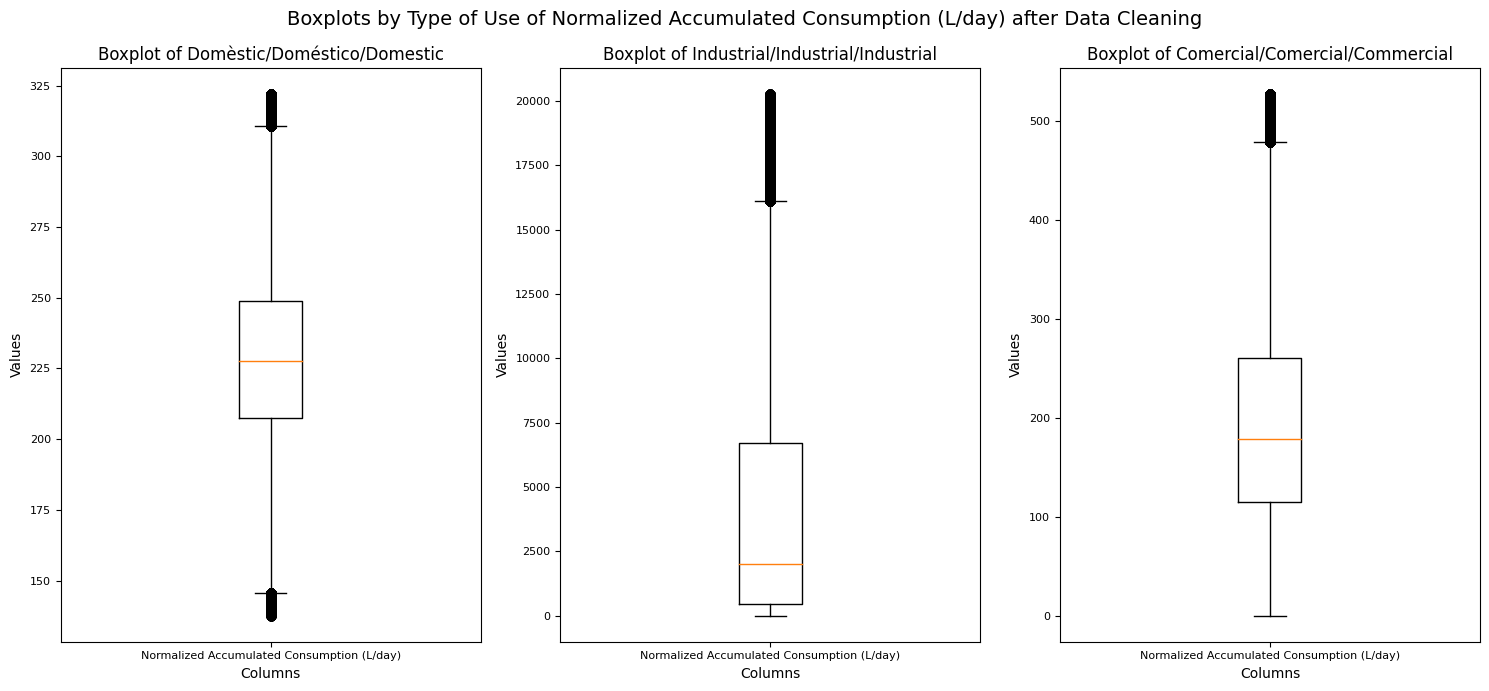

In [140]:
dataset1_box = dataset1_filtered.dropna(subset = ['District'])
dataset1_box = dataset1_box.dropna(subset = ['Census section'])
dataset1_box = dataset1_box.dropna(subset = ['Accumulated Consumption (L/day)'])
dataset1_box = dataset1_box.dropna(subset = ['Normalized Accumulated Consumption (L/day)'])

use_cases = ['Domèstic/Doméstico/Domestic', 'Comercial/Comercial/Commercial', 'Industrial/Industrial/Industrial']
num_plots = len(use_cases)
num_columns = 3
num_rows = int(np.ceil(num_plots / num_columns))

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 7))
axes = axes.flatten()

for i, use_case in enumerate(use_cases):
    iteration_dataset = dataset1_box[dataset1_box['Use'] == use_case].copy()
    columns_to_plot = ['Normalized Accumulated Consumption (L/day)']
    axes[i].boxplot([iteration_dataset[col] for col in columns_to_plot], labels=columns_to_plot)
    axes[i].set_title(f'Boxplot of {use_case}', fontsize=12)
    axes[i].set_xlabel('Columns', fontsize=10)
    axes[i].set_ylabel('Values', fontsize=10)
    axes[i].tick_params(axis='x', labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)

# Hide any unused subplots if the number of use cases is not a multiple of num_columns
for j in range(i + 1, num_rows * num_columns):
    fig.delaxes(axes[j])

fig.suptitle('Boxplots by Type of Use of Normalized Accumulated Consumption (L/day) after Data Cleaning', fontsize=14)
plt.tight_layout()
plt.show()

##### **2.5. Storage of Anomalies**

If all anomalies in the data have been cleaned correctly we should have the sum of the number of outlier values and negatives remaining in our anomalies stored.

Negative values removed = 6222

Outliers removed = 334898 - 6222 = 328676

Total number of anomalies = 334898

In [141]:
# Save current clean dataset for classification of anomalies
clean_data = dataset1_filtered.copy()

anomalies.head()

,Census section,District,Postcode,Municipality,Date,Use,Number of meters,Accumulated Consumption (L/day),Normalized Accumulated Consumption (L/day)
0,NaN,NaN,8001,BARCELONA,2022-04-16,Domèstic/Doméstico/Domestic,46,-12426.0,-270.130
1,NaN,NaN,8002,BARCELONA,2022-10-06,Comercial/Comercial/Commercial,6,-330.0,-55.000
2,NaN,NaN,8003,BARCELONA,2020-06-05,Domèstic/Doméstico/Domestic,84,-574231.0,-6836.083
3,NaN,NaN,8003,BARCELONA,2021-05-02,Comercial/Comercial/Commercial,5,-1.0,-0.200
4,NaN,NaN,8006,BARCELONA,2021-08-10,Industrial/Industrial/Industrial,3,-1.0,-0.333


## 3. Data Enhancement

In [142]:
# Convert "Date" column to datetime
dataset1_filtered['Date'] = pd.to_datetime(dataset1_filtered['Date'])
dataset1_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4820790 entries, 0 to 4820789
Data columns (total 9 columns):
 #   Column                                      Dtype         
---  ------                                      -----         
 0   Census section                              float64       
 1   District                                    float64       
 2   Postcode                                    int64         
 3   Municipality                                object        
 4   Date                                        datetime64[ns]
 5   Use                                         object        
 6   Number of meters                            int64         
 7   Accumulated Consumption (L/day)             float64       
 8   Normalized Accumulated Consumption (L/day)  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 331.0+ MB


In [143]:
# We create a new "Season" column based on the "Date" column
def map_to_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'

dataset1_filtered['Season'] = dataset1_filtered['Date'].dt.month.map(map_to_season)

# We create a new column "Day_of_Week" based on the column "Date"
dataset1_filtered['Day of Week'] = dataset1_filtered['Date'].dt.day_name()

# We create a new column "Month" based on the column "Date"
dataset1_filtered['Month'] = dataset1_filtered['Date'].dt.month

# We create a new column "Year" based on the column "Date"
dataset1_filtered['Year'] = dataset1_filtered['Date'].dt.year

dataset1_filtered.head()

,Census section,District,Postcode,Municipality,Date,Use,Number of meters,Accumulated Consumption (L/day),Normalized Accumulated Consumption (L/day),Season,Day of Week,Month,Year
0,NaN,NaN,8001,BARCELONA,2019-01-01,Domèstic/Doméstico/Domestic,4,819.0,204.75,Winter,Tuesday,1,2019
1,NaN,NaN,8001,BARCELONA,2019-01-02,Domèstic/Doméstico/Domestic,4,1052.0,263.00,Winter,Wednesday,1,2019
2,NaN,NaN,8001,BARCELONA,2019-01-03,Domèstic/Doméstico/Domestic,4,827.0,206.75,Winter,Thursday,1,2019
3,NaN,NaN,8001,BARCELONA,2019-01-04,Domèstic/Doméstico/Domestic,4,833.0,208.25,Winter,Friday,1,2019
4,NaN,NaN,8001,BARCELONA,2019-01-05,Domèstic/Doméstico/Domestic,4,1055.0,263.75,Winter,Saturday,1,2019


As we can see now all data in this dataset ranges from years 2019 to 2022. This is important as now we are going to add new information from other datasets and we are going to need the dates to match.

In [144]:
dataset1_filtered['Year'].unique()

array([2019, 2020, 2021, 2022], dtype=int64)

In [145]:
temperature = 'C:/Users/edith/Desktop/TFG\Datasets/Dades meteorològiques de la XEMA/Temperature_Dades_Meteorologiques_XEMA.csv'
temperature = pd.read_csv(temperature)
temperature['DATA_LECTURA'] = pd.to_datetime(temperature['DATA_LECTURA'])
temperature['DATA_LECTURA'] = temperature['DATA_LECTURA'].dt.date
temperature['DATA_LECTURA'] = pd.to_datetime(temperature['DATA_LECTURA'])
temperature = temperature.groupby(['CODI_ESTACIO', 'DATA_LECTURA'])['VALOR_LECTURA'].mean().reset_index()
temperature.head(5)

,CODI_ESTACIO,DATA_LECTURA,VALOR_LECTURA
0,D5,2019-01-01,10.541667
1,D5,2019-01-02,10.764583
2,D5,2019-01-03,11.568750
3,D5,2019-01-04,12.868750
4,D5,2019-01-05,14.585417


In [146]:
rel_humidity = 'C:/Users/edith/Desktop/TFG\Datasets/Dades meteorològiques de la XEMA/Relative_Humidity_Dades_Meteorologiques_XEMA.csv'
rel_humidity = pd.read_csv(rel_humidity)
rel_humidity['DATA_LECTURA'] = pd.to_datetime(rel_humidity['DATA_LECTURA'])
rel_humidity['DATA_LECTURA'] = rel_humidity['DATA_LECTURA'].dt.date
rel_humidity['DATA_LECTURA'] = pd.to_datetime(rel_humidity['DATA_LECTURA'])
rel_humidity = rel_humidity.groupby(['CODI_ESTACIO', 'DATA_LECTURA'])['VALOR_LECTURA'].mean().reset_index()
rel_humidity.head(5)

,CODI_ESTACIO,DATA_LECTURA,VALOR_LECTURA
0,D5,2019-01-01,72.833333
1,D5,2019-01-02,70.812500
2,D5,2019-01-03,73.875000
3,D5,2019-01-04,52.416667
4,D5,2019-01-05,69.354167


In [147]:
atm_pressure = 'C:/Users/edith/Desktop/TFG\Datasets/Dades meteorològiques de la XEMA/Atmospheric_Pressure_Dades_Meteorologiques_XEMA.csv'
atm_pressure = pd.read_csv(atm_pressure)
atm_pressure['DATA_LECTURA'] = pd.to_datetime(atm_pressure['DATA_LECTURA'])
atm_pressure['DATA_LECTURA'] = atm_pressure['DATA_LECTURA'].dt.date
atm_pressure['DATA_LECTURA'] = pd.to_datetime(atm_pressure['DATA_LECTURA'])
atm_pressure = atm_pressure.groupby(['CODI_ESTACIO', 'DATA_LECTURA'])['VALOR_LECTURA'].mean().reset_index()
atm_pressure.head(5)

,CODI_ESTACIO,DATA_LECTURA,VALOR_LECTURA
0,D5,2019-01-01,979.635417
1,D5,2019-01-02,942.931250
2,D5,2019-01-03,973.860417
3,D5,2019-01-04,966.789583
4,D5,2019-01-05,966.987500


In [148]:
precipitation = 'C:/Users/edith/Desktop/TFG\Datasets/Dades meteorològiques de la XEMA/Precipitation_Dades_Meteorologiques_XEMA.csv'
precipitation = pd.read_csv(precipitation)
precipitation['DATA_LECTURA'] = pd.to_datetime(precipitation['DATA_LECTURA'])
precipitation['DATA_LECTURA'] = precipitation['DATA_LECTURA'].dt.date
precipitation['DATA_LECTURA'] = pd.to_datetime(precipitation['DATA_LECTURA'])
precipitation = precipitation.groupby(['CODI_ESTACIO', 'DATA_LECTURA'])['VALOR_LECTURA'].mean().reset_index()
precipitation.head(5)

,CODI_ESTACIO,DATA_LECTURA,VALOR_LECTURA
0,D5,2019-01-01,0.00000
1,D5,2019-01-02,0.09375
2,D5,2019-01-03,0.00000
3,D5,2019-01-04,0.00000
4,D5,2019-01-05,0.00000


In [149]:
solar_rad = 'C:/Users/edith/Desktop/TFG\Datasets/Dades meteorològiques de la XEMA/Solar_Radation_global_Dades_Meteorologiques_XEMA.csv'
solar_rad = pd.read_csv(solar_rad)
solar_rad['DATA_LECTURA'] = pd.to_datetime(solar_rad['DATA_LECTURA'])
solar_rad['DATA_LECTURA'] = solar_rad['DATA_LECTURA'].dt.date
solar_rad['DATA_LECTURA'] = pd.to_datetime(solar_rad['DATA_LECTURA'])
solar_rad = solar_rad.groupby(['CODI_ESTACIO', 'DATA_LECTURA'])['VALOR_LECTURA'].mean().reset_index()
solar_rad.head(5)

,CODI_ESTACIO,DATA_LECTURA,VALOR_LECTURA
0,D5,2019-01-01,62.416667
1,D5,2019-01-02,87.229167
2,D5,2019-01-03,162.520833
3,D5,2019-01-04,253.291667
4,D5,2019-01-05,308.229167


In [150]:
print("Temperature available station info: ", temperature['CODI_ESTACIO'].unique())
print("Relative Humidity available station info: ", rel_humidity['CODI_ESTACIO'].unique())
print("Atmospheric Pressure available station info: ", atm_pressure['CODI_ESTACIO'].unique())
print("Precipitation available station info: ", precipitation['CODI_ESTACIO'].unique())
print("Solar Radiation global available station info: ", solar_rad['CODI_ESTACIO'].unique())

Temperature available station info:  ['D5' 'UG' 'WU' 'X2' 'X4' 'X8' 'XL']
Relative Humidity available station info:  ['D5' 'UG' 'WU' 'X2' 'X4' 'X8' 'XL']
Atmospheric Pressure available station info:  ['D5' 'WU' 'X4' 'X8']
Precipitation available station info:  ['D5' 'UG' 'WU' 'X4' 'X8' 'XL']
Solar Radiation global available station info:  ['D5' 'UG' 'WU' 'X4' 'X8' 'XL']


In [151]:
postalcode_to_station_temp_relh = {
    8001: 'X4', 8002: 'X4', 8003: 'X2', 8004: 'X4', 8005: 'X2', 8006: 'D5', 8007: 'X4', 8008: 'X4', 8009: 'X4', 8010: 'X4',
    8011: 'X4', 8012: 'D5', 8013: 'X2', 8014: 'XL', 8015: 'X4', 8016: 'D5', 8017: 'X8', 8018: 'X2', 8019: 'X2', 8020: 'X2',
    8021: 'X8', 8022: 'D5', 8023: 'D5', 8024: 'D5', 8025: 'D5', 8026: 'X2', 8027: 'D5', 8028: 'XL', 8029: 'X8', 8030: 'D5',
    8031: 'D5', 8032: 'D5', 8033: 'D5', 8034: 'X8', 8035: 'D5', 8036: 'X4', 8037: 'X4', 8038: 'X4', 8039: 'X4', 8040: 'XL',
    8041: 'D5', 8042: 'D5'
}

postalcode_to_station_atmp = {
    8001: 'X4', 8002: 'X4', 8003: 'X4', 8004: 'X4', 8005: 'X4', 8006: 'D5', 8007: 'X4', 8008: 'X4', 8009: 'X4', 8010: 'X4',
    8011: 'X4', 8012: 'D5', 8013: 'X4', 8014: 'D5', 8015: 'X4', 8016: 'D5', 8017: 'X8', 8018: 'X4', 8019: 'X4', 8020: 'X4',
    8021: 'X8', 8022: 'D5', 8023: 'D5', 8024: 'D5', 8025: 'D5', 8026: 'X4', 8027: 'D5', 8028: 'D5', 8029: 'X8', 8030: 'D5',
    8031: 'D5', 8032: 'D5', 8033: 'D5', 8034: 'X8', 8035: 'D5', 8036: 'X4', 8037: 'X4', 8038: 'X4', 8039: 'X4', 8040: 'D5',
    8041: 'D5', 8042: 'D5'
}

postalcode_to_station_prec_sol = {
    8001: 'X4', 8002: 'X4', 8003: 'X4', 8004: 'X4', 8005: 'X4', 8006: 'D5', 8007: 'X4', 8008: 'X4', 8009: 'X4', 8010: 'X4',
    8011: 'X4', 8012: 'D5', 8013: 'X4', 8014: 'XL', 8015: 'X4', 8016: 'D5', 8017: 'X8', 8018: 'X4', 8019: 'X4', 8020: 'X4',
    8021: 'X8', 8022: 'D5', 8023: 'D5', 8024: 'D5', 8025: 'D5', 8026: 'X4', 8027: 'D5', 8028: 'XL', 8029: 'X8', 8030: 'D5',
    8031: 'D5', 8032: 'D5', 8033: 'D5', 8034: 'X8', 8035: 'D5', 8036: 'X4', 8037: 'X4', 8038: 'X4', 8039: 'X4', 8040: 'XL',
    8041: 'D5', 8042: 'D5'
}

municipality_to_station_temp_relh_prec_sol = { "GAVA": "UG", "VILADECANS": "UG", "SANT ADRIA": "WU", "L'HOSPITALET LLOBR.": "XL", "SANT FELIU LL.": "X8" }
municipality_to_station_atmp = { "GAVA": "D5", "VILADECANS": "D5", "SANT ADRIA": "WU", "L'HOSPITALET LLOBR.": "XL", "SANT FELIU LL.": "X8" }

In [152]:
def mapping_geotemporal(dataset, geotemporal, attribute, municipality_to_station, postalcode_to_station):
    
    # Split in two different datasets for CODI_ESTACIO mapping
    dataset_filtered = dataset[dataset['Municipality'].isin(municipality_to_station.keys())]
    dataset_barcelona = dataset[dataset['Municipality'] == "BARCELONA"]

    dataset_filtered['CODI_ESTACIO'] = dataset_filtered['Municipality'].map(municipality_to_station)
    dataset_barcelona['CODI_ESTACIO'] = dataset_barcelona['Postcode'].map(postalcode_to_station)

    # Combine datasets back together
    dataset_combined = pd.concat([dataset_filtered, dataset_barcelona])

    # Merge dataset with geotemporal on 'CODI_ESTACIO' and 'Date'
    dataset = pd.merge(
        dataset_combined, 
        geotemporal, 
        left_on=['CODI_ESTACIO', 'Date'], 
        right_on=['CODI_ESTACIO', 'DATA_LECTURA'],
        how='left'
    )

    # Drop 'CODI_ESTACIO' and 'DATA_LECTURA' and rename 'VALOR_LECTURA'
    dataset.drop(columns=['CODI_ESTACIO', 'DATA_LECTURA'], inplace=True)
    dataset.rename(columns = {'VALOR_LECTURA': attribute}, inplace=True)

    return dataset


dataset1_filtered = mapping_geotemporal(dataset1_filtered, temperature, "Temperature", municipality_to_station_temp_relh_prec_sol, postalcode_to_station_temp_relh)
dataset1_filtered = mapping_geotemporal(dataset1_filtered, rel_humidity, "Relative Humidity", municipality_to_station_temp_relh_prec_sol, postalcode_to_station_temp_relh)
dataset1_filtered = mapping_geotemporal(dataset1_filtered, atm_pressure, "Atmospheric Pressure", municipality_to_station_atmp, postalcode_to_station_atmp)
dataset1_filtered = mapping_geotemporal(dataset1_filtered, precipitation, "Precipitation", municipality_to_station_temp_relh_prec_sol, postalcode_to_station_prec_sol)
dataset1_filtered = mapping_geotemporal(dataset1_filtered, solar_rad, "Solar Radation global", municipality_to_station_temp_relh_prec_sol, postalcode_to_station_prec_sol)
dataset1_filtered


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,Census section,District,Postcode,Municipality,Date,Use,Number of meters,Accumulated Consumption (L/day),Normalized Accumulated Consumption (L/day),Season,Day of Week,Month,Year,Temperature,Relative Humidity,Atmospheric Pressure,Precipitation,Solar Radation global
0,NaN,NaN,8850,GAVA,2019-01-01,Domèstic/Doméstico/Domestic,7,1570.0,224.286,Winter,Tuesday,1,2019,9.412500,75.041667,979.635417,0.00000,94.750000
1,NaN,NaN,8850,GAVA,2019-01-02,Domèstic/Doméstico/Domestic,7,1412.0,201.714,Winter,Wednesday,1,2019,12.406250,75.750000,942.931250,0.00625,85.375000
2,NaN,NaN,8850,GAVA,2019-01-03,Domèstic/Doméstico/Domestic,7,NaN,NaN,Winter,Thursday,1,2019,11.452083,78.916667,973.860417,0.00000,180.645833
3,NaN,NaN,8850,GAVA,2019-01-04,Domèstic/Doméstico/Domestic,7,NaN,NaN,Winter,Friday,1,2019,13.729167,64.291667,966.789583,0.00000,243.854167
4,NaN,NaN,8850,GAVA,2019-01-05,Domèstic/Doméstico/Domestic,7,1144.0,163.429,Winter,Saturday,1,2019,15.527083,79.270833,966.987500,0.00000,309.541667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4820785,810103020.0,3.0,8038,BARCELONA,2022-12-27,Comercial/Comercial/Commercial,11,2793.0,253.909,Winter,Tuesday,12,2022,14.689583,73.083333,1025.577083,0.00000,97.625000
4820786,810103020.0,3.0,8038,BARCELONA,2022-12-28,Comercial/Comercial/Commercial,11,2754.0,250.364,Winter,Wednesday,12,2022,13.389583,72.625000,1020.614583,0.00000,99.500000
4820787,810103020.0,3.0,8038,BARCELONA,2022-12-29,Comercial/Comercial/Commercial,11,2423.0,220.273,Winter,Thursday,12,2022,14.506250,59.062500,1016.462500,0.00000,77.229167
4820788,810103020.0,3.0,8038,BARCELONA,2022-12-30,Comercial/Comercial/Commercial,11,2493.0,226.636,Winter,Friday,12,2022,16.308333,57.166667,1017.022917,0.00000,61.291667


In [153]:
# Null values per column
columns_dataset1 = dataset1_filtered.columns
for column in columns_dataset1:
  print("Column:", column, "- Null values: ", dataset1_filtered[column].isnull().sum())

Column: Census section - Null values:  135983
Column: District - Null values:  135983
Column: Postcode - Null values:  0
Column: Municipality - Null values:  0
Column: Date - Null values:  0
Column: Use - Null values:  0
Column: Number of meters - Null values:  0
Column: Accumulated Consumption (L/day) - Null values:  334898
Column: Normalized Accumulated Consumption (L/day) - Null values:  334898
Column: Season - Null values:  0
Column: Day of Week - Null values:  0
Column: Month - Null values:  0
Column: Year - Null values:  0
Column: Temperature - Null values:  9706
Column: Relative Humidity - Null values:  9706
Column: Atmospheric Pressure - Null values:  662279
Column: Precipitation - Null values:  9706
Column: Solar Radation global - Null values:  9706


In [154]:
# # Precipitation Over Time
# df_sorted = dataset1_filtered.sort_values(by='Date')
# plt.figure(figsize=(10, 5))
# plt.plot(df_sorted['Date'], df_sorted['Precipitation'], color='blue', linewidth=2)
# plt.xlabel('Date', fontsize=10)
# plt.ylabel('Precipitation (mm)', fontsize=10)
# plt.title('Precipitation Over Time', fontsize=12)
# plt.xticks(fontsize=8)
# plt.yticks(fontsize=8)
# plt.show()

## 4. Data Prediction

In order to do the projection of incorrect values (negative and outliers) that right now happen to be null values in the dataset, we will implement several data prediction models, compare their results and conclude which gives the best results for our data.

We will now encode the variables that aren't numerical in order to work with them and plot a correlation matrix to see which features explain best our target variable, Accumulated Consumption (L/day). We are making a prediction with Accumulated Consumption (L/day) instead of the normalized data because it was the original one and shows more promising results. At the end we just have to divide by the Number of Meters.

In [155]:
# Convert "Date" column to object for label encoding
dataset1_filtered['Date'] = dataset1_filtered['Date'].astype(object)

In [156]:
# Label Encoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder to each column containing categorical data
for column in dataset1_filtered.columns:
    if dataset1_filtered[column].dtype == 'object':
        dataset1_filtered[column] = label_encoder.fit_transform(dataset1_filtered[column])

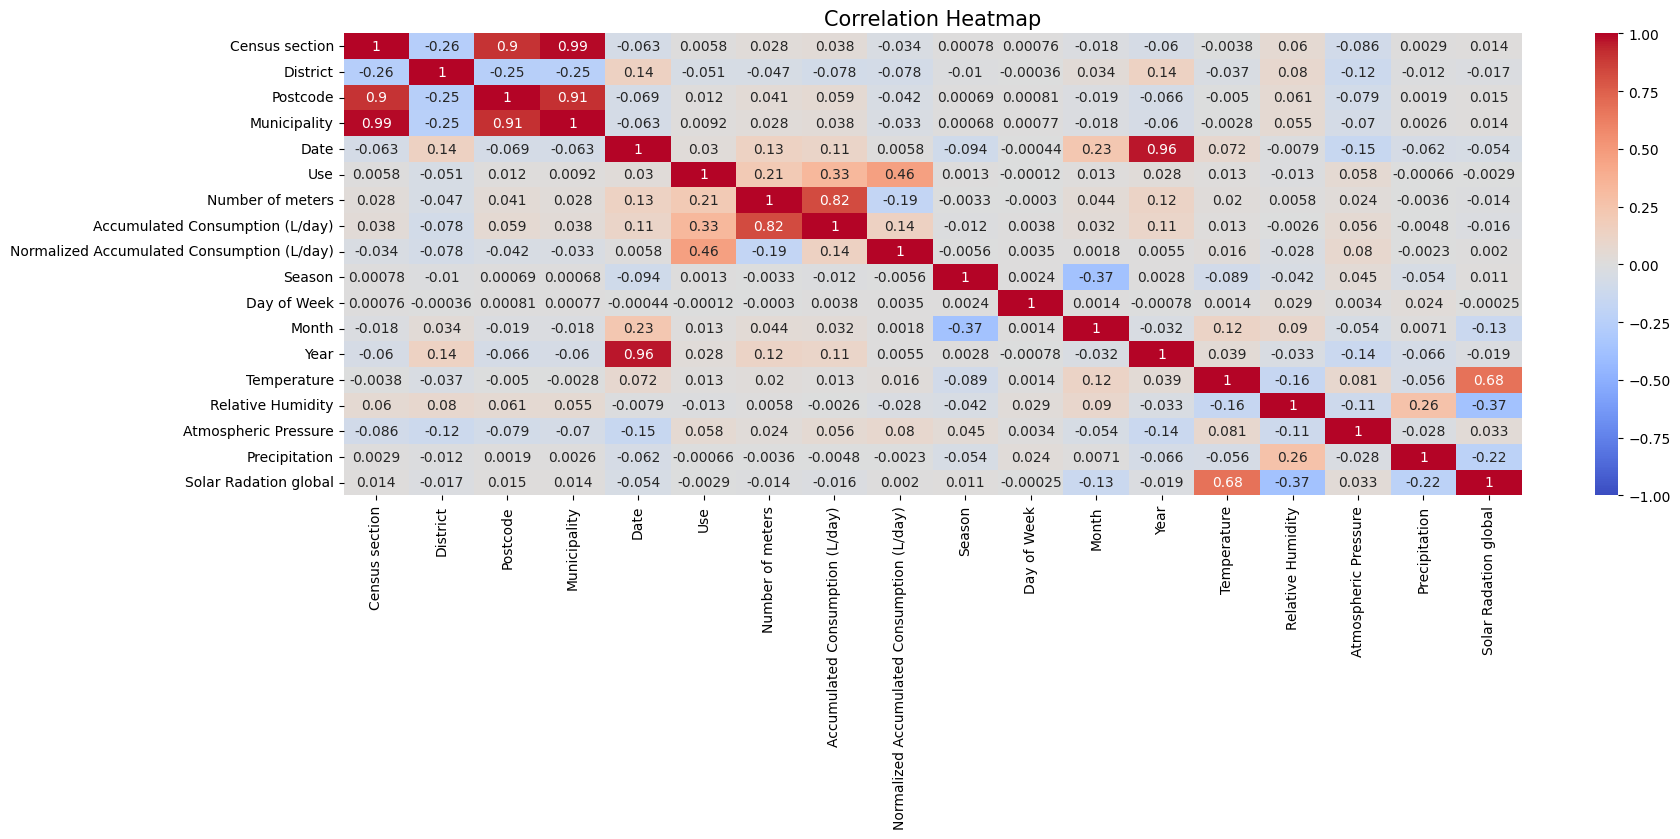

In [157]:
# We remove the null values to see the correct correlation of the data
dataset1_filtered = dataset1_filtered.dropna(subset = ['District'])
dataset1_filtered = dataset1_filtered.dropna(subset = ['Census section'])
dataset1_filtered = dataset1_filtered.dropna(subset = ['Temperature'])
dataset1_filtered = dataset1_filtered.dropna(subset = ['Relative Humidity'])
dataset1_filtered = dataset1_filtered.dropna(subset = ['Atmospheric Pressure'])
dataset1_filtered = dataset1_filtered.dropna(subset = ['Precipitation'])
dataset1_filtered = dataset1_filtered.dropna(subset = ['Solar Radation global'])

dataset1_filtered_not_null = dataset1_filtered[~dataset1_filtered['Accumulated Consumption (L/day)'].isnull()]
corr = dataset1_filtered_not_null.corr()
plt.figure(figsize=(19,6))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize': 15})
plt.show()

##### **4.1. Linear Regression**

In [43]:
# Model Training

# We remove the null values in the consumption column to train the model
dataset1_filtered2 = dataset1_filtered.dropna(subset=['Accumulated Consumption (L/day)'])

# Independent variables 
features = ['Census section','District','Postcode','Municipality','Date','Use','Number of meters','Season','Day of Week','Month',
            'Year','Temperature','Relative Humidity','Atmospheric Pressure','Precipitation','Solar Radation global']

X = dataset1_filtered2[features]

# Target variable (dependent variable)
y = dataset1_filtered2['Accumulated Consumption (L/day)']

# 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We make sure that X and Y have the same length for both train and test
print("Lenght X_train:", len(X_train))
print("Length y_train:", len(y_train))
print("Lenght X_test:", len(X_test))
print("Length y_test:", len(y_test))

Lenght X_train: 2997222
Length y_train: 2997222
Lenght X_test: 749306
Length y_test: 749306


In [44]:
# Create a model
lr_model = LinearRegression()

# Create RFECV object with custom parameters
selector = RFECV(estimator=lr_model, step=1, cv=5, min_features_to_select=3) # 5-fold cross-validation

# Fit RFECV
selector = selector.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[selector.support_]

# Train model with selected features
lr_model.fit(X_train[selected_features], y_train)

# Predict on the test set
y_pred = lr_model.predict(X_test[selected_features])

# Evaluate the model
mse_lr = mean_squared_error(y_test, y_pred)
mae_lr = mean_absolute_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)

print(f"Linear Regression Mean Squared Error (MSE): {round(np.sqrt(mse_lr), 4)}")
print(f"Linear Regression Mean Absolute Error (MAE): {round(mae_lr, 4)}")
print(f"Linear Regression R-squared (R2): {round(r2_lr, 4)}")
print("\nSelected independent variables: ", selected_features)


Linear Regression Mean Squared Error (MSE): 27143.0035
Linear Regression Mean Absolute Error (MAE): 9473.7397
Linear Regression R-squared (R2): 0.709

Selected independent variables:  Index(['Census section', 'District', 'Postcode', 'Municipality', 'Date', 'Use',
       'Number of meters', 'Season', 'Day of Week', 'Month', 'Year',
       'Temperature', 'Relative Humidity', 'Atmospheric Pressure',
       'Precipitation', 'Solar Radation global'],
      dtype='object')


##### **4.2. Random Forest**

The Random Forest feature selection cannot be done by using the complete dataset as it could take days. That is why I am applying the feature selection to only a subset of the data and later I will apply the selected independent variables to the whole dataset.

In [51]:
# Model Training

# We remove the null values in the consumption column to train the model
dataset1_filtered2 = dataset1_filtered.dropna(subset=['Accumulated Consumption (L/day)'])

# Reduce the working dataset
rows = len(dataset1_filtered2) // 90
dataset1_filtered2 = dataset1_filtered2.sample(n=rows, random_state=42)

# Independent variables 
features = ['Census section','District','Postcode','Municipality','Date','Use','Number of meters','Season','Day of Week','Month',
            'Year','Temperature','Relative Humidity','Atmospheric Pressure','Precipitation','Solar Radation global']

X = dataset1_filtered2[features]

# Target variable (dependent variable)
y = dataset1_filtered2['Accumulated Consumption (L/day)']

# 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We make sure that X and Y have the same length for both train and test
print("Lenght X_train:", len(X_train))
print("Length y_train:", len(y_train))
print("Lenght X_test:", len(X_test))
print("Length y_test:", len(y_test))

Lenght X_train: 33302
Length y_train: 33302
Lenght X_test: 8326
Length y_test: 8326


In [52]:
# Create a model
rf_model = RandomForestRegressor(random_state=42)

# Create RFECV object with custom parameters
selector = RFECV(estimator=rf_model, step=1, cv=5, min_features_to_select=3) # 5-fold cross-validation

# Fit RFECV
selector = selector.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[selector.support_]

# Train model with selected features
rf_model.fit(X_train[selected_features], y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test[selected_features])

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred)
mae_rf = mean_absolute_error(y_test, y_pred)
r2_rf = r2_score(y_test, y_pred)

print(f"Random Forest Mean Squared Error (MSE):", round(np.sqrt(mse_rf), 4))
print(f"Random Forest Mean Absolute Error (MAE): {round(mae_rf, 4)}")
print(f"Random Forest R-squared (R2):", round(r2_rf, 4))
print("\nSelected independent variables: ", selected_features)

Random Forest Mean Squared Error (MSE): 15268.4158
Random Forest Mean Absolute Error (MAE): 6337.035
Random Forest R-squared (R2): 0.9126

Selected independent variables:  Index(['Census section', 'Postcode', 'Date', 'Use', 'Number of meters',
       'Temperature', 'Relative Humidity', 'Atmospheric Pressure'],
      dtype='object')


In [54]:
# Model Training

# We remove the null values in the consumption column to train the model
dataset1_filtered2 = dataset1_filtered.dropna(subset=['Accumulated Consumption (L/day)'])

# Reduce the working dataset
rows = len(dataset1_filtered2)
dataset1_filtered2 = dataset1_filtered2.iloc[:rows]

# Independent variables 
features = ['Census section','District','Postcode','Municipality','Date','Use','Number of meters','Season','Day of Week','Month',
            'Year','Temperature','Relative Humidity','Atmospheric Pressure','Precipitation','Solar Radation global']

X = dataset1_filtered2[features]

# Target variable (dependent variable)
y = dataset1_filtered2['Accumulated Consumption (L/day)']

# 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We make sure that X and Y have the same length for both train and test
print("Lenght X_train:", len(X_train))
print("Length y_train:", len(y_train))
print("Lenght X_test:", len(X_test))
print("Length y_test:", len(y_test))

Lenght X_train: 2997222
Length y_train: 2997222
Lenght X_test: 749306
Length y_test: 749306


In [55]:
# Random Forest 78min
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Mean Squared Error (MSE):", round(np.sqrt(mse_rf), 4))
print(f"Random Forest Mean Absolute Error (MAE): {round(mae_rf, 4)}")
print(f"Random Forest R-squared (R2):", round(r2_rf, 4))

Random Forest Mean Squared Error (MSE): 8513.2641
Random Forest Mean Absolute Error (MAE): 3368.8854
Random Forest R-squared (R2): 0.9714


##### **4.3. XGBoost**

In [55]:
# Model Training

# We remove the null values in the consumption column to train the model
dataset1_filtered2 = dataset1_filtered.dropna(subset=['Accumulated Consumption (L/day)'])

# Independent variables 
features = ['Census section','District','Postcode','Municipality','Date','Use','Number of meters','Season','Day of Week','Month',
            'Year','Temperature','Relative Humidity','Atmospheric Pressure','Precipitation','Solar Radation global']

X = dataset1_filtered2[features]

# Target variable (dependent variable)
y = dataset1_filtered2['Accumulated Consumption (L/day)']

# 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We make sure that X and Y have the same length for both train and test
print("Lenght X_train:", len(X_train))
print("Length y_train:", len(y_train))
print("Lenght X_test:", len(X_test))
print("Length y_test:", len(y_test))

Lenght X_train: 2997222
Length y_train: 2997222
Lenght X_test: 749306
Length y_test: 749306


In [56]:
# Create a model
xgb_model = xgb.XGBRegressor(random_state=42)

# Create RFECV object with custom parameters
selector = RFECV(estimator=xgb_model, step=1, cv=5, min_features_to_select=3) # 5-fold cross-validation

# Fit RFECV
selector = selector.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[selector.support_]

# Train model with selected features
xgb_model.fit(X_train[selected_features], y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test[selected_features])

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred)
mae_xgb = mean_absolute_error(y_test, y_pred)
r2_xgb = r2_score(y_test, y_pred)

print(f"XGBoost Mean Squared Error (MSE):", round(np.sqrt(mse_xgb), 4))
print(f"XGBoost Mean Absolute Error (MAE): {round(mae_xgb, 4)}")
print(f"XGBoost R-squared (R2):", round(r2_xgb, 4))
print("\nSelected independent variables: ", selected_features)

XGBoost Mean Squared Error (MSE): 10762.749
XGBoost Mean Absolute Error (MAE): 5251.9952
XGBoost R-squared (R2): 0.9542

Selected independent variables:  Index(['Census section', 'District', 'Postcode', 'Date', 'Use',
       'Number of meters', 'Season', 'Day of Week', 'Month', 'Temperature',
       'Relative Humidity', 'Atmospheric Pressure', 'Solar Radation global'],
      dtype='object')


##### **4.4. K-Nearest Neighbors**

In [57]:
# # Range of k values to test
# k_values = range(1, 2)
# mse_values = []

# # Evaluation of the model for each k value
# for k in k_values:
#     knn_model = KNeighborsRegressor(n_neighbors=k)
#     knn_model.fit(X_train, y_train)
#     y_pred_knn = knn_model.predict(X_test)
#     mse = mean_squared_error(y_test, y_pred_knn)
#     mse_values.append(mse)

# # Plot error rates vs k values
# plt.figure(figsize=(10, 6))
# plt.plot(k_values, mse_values, marker='o', linestyle='dashed', color='b')
# plt.xlabel('Number of Neighbors K', fontsize=10)
# plt.ylabel('Mean Squared Error (MSE)', fontsize=10)
# plt.title('Error Rate vs. K Value', fontsize=12)
# plt.xticks(k_values)
# plt.grid(True)
# plt.show()

# # k value with the minimum error rate
# best_k = k_values[np.argmin(mse_values)]
# print(f"The best k value is: {best_k}")

In [160]:
# Model Training

# We remove the null values in the consumption column to train the model
dataset1_filtered2 = dataset1_filtered.dropna(subset=['Accumulated Consumption (L/day)'])

# Independent variables 
features = ['Census section','District','Postcode','Municipality','Date','Use','Number of meters','Season','Day of Week','Month',
            'Year','Temperature','Relative Humidity','Atmospheric Pressure','Precipitation','Solar Radation global']

X = dataset1_filtered2[features]

# Target variable (dependent variable)
y = dataset1_filtered2['Accumulated Consumption (L/day)']

# 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We make sure that X and Y have the same length for both train and test
print("Lenght X_train:", len(X_train))
print("Length y_train:", len(y_train))
print("Lenght X_test:", len(X_test))
print("Length y_test:", len(y_test))

Lenght X_train: 2997222
Length y_train: 2997222
Lenght X_test: 749306
Length y_test: 749306


In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

# Create a model
knn_model = KNeighborsRegressor(n_neighbors=2)

# Create SequentialFeatureSelector object with custom parameters
sfs = SequentialFeatureSelector(estimator=knn_model, n_features_to_select='auto', tol=0.02, direction='forward', cv=5)

# Fit SequentialFeatureSelector
sfs.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[sfs.get_support()]

# Train model with selected features
knn_model.fit(X_train[selected_features], y_train)

# Predict on the test set
y_pred = knn_model.predict(X_test[selected_features])

# Evaluate the model
mse_knn = mean_squared_error(y_test, y_pred)
mae_knn = mean_absolute_error(y_test, y_pred)
r2_knn = r2_score(y_test, y_pred)

print(f"K-Nearest Neighbors Mean Squared Error (MSE): {round(np.sqrt(mse_knn), 4)}")
print(f"K-Nearest Neighbors Mean Absolute Error (MAE): {round(mae_knn, 4)}")
print(f"K-Nearest Neighbors R-squared (R2): {round(r2_knn, 4)}")
print("\nSelected independent variables: ", selected_features)

In [ ]:
# # K-Nearest Neighbors
# knn_model = KNeighborsRegressor(n_neighbors=2)
# knn_model.fit(X_train, y_train)
# y_pred_knn = knn_model.predict(X_test)

# # Evaluate the model
# mse_knn = mean_squared_error(y_test, y_pred_knn)
# mae_knn = mean_absolute_error(y_test, y_pred_knn)
# r2_knn = r2_score(y_test, y_pred_knn)

# print(f"K-Nearest Neighbors Mean Squared Error (MSE):", round(np.sqrt(mse_knn), 4))
# print(f"K-Nearest Neighbors Mean Absolute Error (MAE): {round(mae_knn, 4)}")
# print(f"K-Nearest Neighbors R-squared (R2):", round(r2_knn, 4))

##### **4.5. Support Vector Machine**

In [ ]:
# Model Training

# We remove the null values in the consumption column to train the model
dataset1_filtered2 = dataset1_filtered.dropna(subset=['Accumulated Consumption (L/day)'])

# Reduce the working dataset
rows = len(dataset1_filtered2) // 500
dataset1_filtered2 = dataset1_filtered2.sample(n=rows, random_state=42)

# Independent variables 
features = ['Census section','District','Postcode','Municipality','Date','Use','Number of meters','Season','Day of Week','Month',
            'Year','Temperature','Relative Humidity','Atmospheric Pressure','Precipitation','Solar Radation global']

X = dataset1_filtered2[features]

# Target variable (dependent variable)
y = dataset1_filtered2['Accumulated Consumption (L/day)']

# 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We make sure that X and Y have the same length for both train and test
print("Lenght X_train:", len(X_train))
print("Length y_train:", len(y_train))
print("Lenght X_test:", len(X_test))
print("Length y_test:", len(y_test))

In [ ]:
# Create a model
svm_model = SVR()

# Create RFECV object with custom parameters
selector = RFECV(estimator=svm_model, step=1, cv=5, min_features_to_select=3) # 5-fold cross-validation

# Fit RFECV
selector = selector.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[selector.support_]

# Train model with selected features
svm_model.fit(X_train[selected_features], y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test[selected_features])

# Evaluate the model
mse_svm = mean_squared_error(y_test, y_pred)
mae_svm = mean_absolute_error(y_test, y_pred)
r2_svm = r2_score(y_test, y_pred)

print(f"Support Vector Machine Mean Squared Error (MSE):", round(np.sqrt(mse_svm), 4))
print(f"Support Vector Machine Mean Absolute Error (MAE): {round(mae_svm, 4)}")
print(f"Support Vector Machine R-squared (R2):", round(r2_svm, 4))
print("\nSelected independent variables: ", selected_features)

In [ ]:
# # Support Vector Machine
# svm_model = SVR()
# svm_model.fit(X_train, y_train)
# y_pred_svm = svm_model.predict(X_test)

# # Evaluate the model
# mse_svm = mean_squared_error(y_test, y_pred_svm)
# mae_svm = mean_absolute_error(y_test, y_pred_svm)
# r2_svm = r2_score(y_test, y_pred_svm)

# print(f"Support Vector Machine Mean Squared Error (MSE):", round(np.sqrt(mse_svm), 4))
# print(f"Support Vector Machine Mean Absolute Error (MAE): {round(mae_svm, 4)}")
# print(f"Support Vector Machine R-squared (R2):", round(r2_svm, 4))

In [ ]:
# Store the model
data = {"model": rf_model, "label_encoder": label_encoder}

with open('model.pkl', 'wb') as file:
    pickle.dump(data, file)

##### **4.6. Explainability**

In [ ]:
# Convert the data to numpy arrays
X_train_array = X_train.values
X_test_array = X_test.values

# We use a small subset of the training data to initialize the SHAP KernelExplainer
background = shap.kmeans(X_train_array, 10)
explainer = shap.KernelExplainer(knn_model.predict, background)

In [ ]:
# We compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_array)

In [ ]:
# Convert shap_values to Explanation objects
shap_values_exp = shap.Explanation(values=shap_values, base_values=explainer.expected_value, data=X_test_array, feature_names=features)

# Visualize SHAP values
shap.initjs()

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
features = ['Use', 'Number of meters', 'Date', 'Postcode', 'Census section']

# Plot layout
fig, axs = plt.subplots(2, 3, figsize=(20, 10))  # 2 rows, 3 columns
axs = axs.flatten()

# Dependence plots
for i, ft in enumerate(features):
    shap.dependence_plot(ft, shap_values, X_test, ax=axs[i], show=False)

# Hide the empty subplot (the 6th plot space)
fig.delaxes(axs[-1])

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# For a single prediction
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])

In [ ]:
shap.waterfall_plot(shap_values_exp[0])

In [ ]:
shap.decision_plot(shap_values_exp[0].base_values, shap_values_exp[0].values, X_test.iloc[0])

In [ ]:
features = ['Use', 'Number of meters', 'Date', 'Postcode', 'Census section']

# Plot layout
fig, axs = plt.subplots(2, 3, figsize=(20, 10))  # 2 rows, 3 columns
axs = axs.flatten()

# Scatter plots
for i, ft in enumerate(features):
    shap.plots.scatter(shap_values_exp[:, ft], ax=axs[i], show=False)

# Hide the empty subplot (the 6th plot space)
fig.delaxes(axs[-1])

# Adjust layout
plt.tight_layout()
plt.show()

##### **4.7. Conclusions on Data Prediction Algorithms**

Based on the R-squared values obtained per each model I conclude that the K-Nearest Neighbors model, with 0.9705, is the most accurate for dataset1_v2.csv data. It is considered a good model if the R-squared value is higher than 0.9. Therefore now we will replace the missing values with the predictions of this model. We have already trained model so now we replace all null values.

In [ ]:
# Identify the rows that have a NUll values in 'Accumulated Consumption (L/day)'
missing_rows = dataset1_filtered[dataset1_filtered['Accumulated Consumption (L/day)'].isnull()]

features2 = ['Use', 'Number of meters', 'Date', 'Postcode', 'Census section']
X_ = missing_rows[features2]

# Predict the values with the model
predicted_values = knn_model.predict(X_)

dataset1_filtered.loc[missing_rows.index, 'Accumulated Consumption (L/day)'] = predicted_values

We now check that no null values nor negatives are in the dataset.

In [ ]:
# Number of null values in Accumulated Consumption (L/day)
print("Number of Nulls in the dataset:", dataset1_filtered['Accumulated Consumption (L/day)'].isnull().sum())

# Number of negatives values in Accumulated Consumption (L/day)
print("Number of Negatives in the dataset:", len(dataset1_filtered[dataset1_filtered['Accumulated Consumption (L/day)'] < 0]))

In order to keep working with our normalized values lets once again put all null values in 'Normalized Accumulated Consumption (L/day)' by diving the consumption by the number of meters.

In [ ]:
predicted_values = dataset1_filtered['Accumulated Consumption (L/day)'] / dataset1_filtered['Number of meters']

dataset1_filtered.loc[dataset1_filtered['Normalized Accumulated Consumption (L/day)'].isnull(), 'Normalized Accumulated Consumption (L/day)'] = predicted_values

In [ ]:
# Number of null values in Normalized Accumulated Consumption (L/day)
print("Number of Nulls in the dataset:", dataset1_filtered['Normalized Accumulated Consumption (L/day)'].isnull().sum())

# Number of negatives values in Normalized Accumulated Consumption (L/day)
print("Number of Negatives in the dataset:", len(dataset1_filtered[dataset1_filtered['Normalized Accumulated Consumption (L/day)'] < 0]))

Lets visualize the Consumption after having cleaned and projected the incorrect values.

In [ ]:
# PLOTS

## 5. Analysis of anomalies

##### **5.1. Classification Criteria**

Previously, we stored all anomalies for later analysis. We are now going to state a classification criteria in order to classify said anomalies into 3 categories: leak or waste, system error or correct but misclassified.
This classification is based on the average of the correct real data, I'm not using the predicted one by the models but it might not be very accurate. This should be done with specific data portraying leaks, waste and system errors.

In [ ]:
# % of anomalies with respect to the original dataset
percentage = (334898 / 4820790 ) * 100
print("% of anomalies with respect to the original dataset: ", round(percentage, 2), "%")

In [ ]:
# Count of Outliers and Negative values
outliers_count = (anomalies['Normalized Accumulated Consumption (L/day)'] > 0).sum()
negative_count = (anomalies['Normalized Accumulated Consumption (L/day)'] < 0).sum()

total_count = len(anomalies)
outliers_percentage = (outliers_count / total_count) * 100
negative_percentage = (negative_count / total_count) * 100

labels = ['Outliers', 'Negative Consumption']
sizes = [outliers_percentage, negative_percentage]
colors = ['cornflowerblue', 'lightskyblue']

# Plotting the pie chart
plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Outliers and Negative Consumption')
plt.axis('equal')
plt.show()

Now we compute the minimum, average and maximum values per type of Use so we can classify each values accordingly.

In [ ]:
# For each type of Use we can compute the min, average and max values
grouped_data = clean_data.groupby('Use')['Normalized Accumulated Consumption (L/day)'].agg(['min', 'mean', 'max'])

# Accessing min, average, and max values for a specific 'Use' type
use_type = 'Domèstic/Doméstico/Domestic'
domestic_min = grouped_data.loc[use_type, 'min']
domestic_average = grouped_data.loc[use_type, 'mean']
domestic_max = grouped_data.loc[use_type, 'max']

use_type = 'Comercial/Comercial/Commercial'
commercial_min = grouped_data.loc[use_type, 'min']
commercial_average = grouped_data.loc[use_type, 'mean']
commercial_max = grouped_data.loc[use_type, 'max']

use_type = 'Industrial/Industrial/Industrial'
industrial_min = grouped_data.loc[use_type, 'min']
industrial_average = grouped_data.loc[use_type, 'mean']
industrial_max = grouped_data.loc[use_type, 'max']

grouped_data

##### **5.2. Anomalies classification**

The following function gets the anomalies dataset and depending on the type of Use applies a classification. I considered consumption values over the maximum value to be of type 'Leak or Waste'. If the consumption is negative then I consider this a 'Data Collection System Error' and in case of not belonging in any of these two groups then the value would be 'Correct but Misclassified'.

In [ ]:
def anomalies_classification(dataset_anomalies):
    if dataset_anomalies['Use'] == 'Domèstic/Doméstico/Domestic':
        if dataset_anomalies['Normalized Accumulated Consumption (L/day)'] > domestic_max:
            return 'Leak or Waste'
        elif dataset_anomalies['Normalized Accumulated Consumption (L/day)'] < 0:
            return 'Data Collection System Error'
        else:
            return 'Correct but Misclassified'
        
    elif dataset_anomalies['Use'] == 'Comercial/Comercial/Commercial':
        if dataset_anomalies['Normalized Accumulated Consumption (L/day)'] > commercial_max:
            return 'Leak or Waste'
        elif dataset_anomalies['Normalized Accumulated Consumption (L/day)'] < 0:
            return 'Data Collection System Error'
        else:
            return 'Correct but Misclassified'
        
    elif dataset_anomalies['Use'] == 'Industrial/Industrial/Industrial':
        if dataset_anomalies['Normalized Accumulated Consumption (L/day)'] > industrial_max:
            return 'Leak or Waste'
        elif dataset_anomalies['Normalized Accumulated Consumption (L/day)'] < 0:
            return 'Data Collection System Error'
        else:
            return 'Correct but Misclassified'
    

anomalies['Classification'] = anomalies.apply(anomalies_classification, axis=1)
anomalies.head()

Now we can visualize the new classification in total and per type of Use.

In [ ]:
# Count occurrences of each classification
classification_counts = anomalies['Classification'].value_counts()
labels = classification_counts.index
sizes = classification_counts.values
colors = ['lightskyblue', 'blue', 'cornflowerblue']

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Anomalies Classification')
plt.axis('equal')
plt.show()

In [ ]:
# Filter the DataFrame
domestic_anomalies = anomalies[anomalies['Use'] == 'Domèstic/Doméstico/Domestic']

# Count occurrences of each classification
classification_counts = domestic_anomalies['Classification'].value_counts()
labels = classification_counts.index
sizes = classification_counts.values
colors = ['lightskyblue', 'blue', 'cornflowerblue'] 

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Anomalies Classification for Domestic Use')
plt.axis('equal')
plt.show()

In [ ]:
# Filter the DataFrame
domestic_anomalies = anomalies[anomalies['Use'] == 'Comercial/Comercial/Commercial']

# Count occurrences of each classification
classification_counts = domestic_anomalies['Classification'].value_counts()
labels = classification_counts.index
sizes = classification_counts.values
colors = ['lightskyblue', 'blue', 'cornflowerblue']

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Each Anomaly Classification for Commercial Use')
plt.axis('equal') 
plt.show()

In [ ]:
# Filter the DataFrame
domestic_anomalies = anomalies[anomalies['Use'] == 'Industrial/Industrial/Industrial']

# Count occurrences of each classification
classification_counts = domestic_anomalies['Classification'].value_counts()
labels = classification_counts.index
sizes = classification_counts.values
colors = ['lightskyblue', 'blue', 'cornflowerblue']

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Each Anomaly Classification for Industrial Use')
plt.axis('equal')
plt.show()

In [ ]:
# Download anomalies
anomalies.to_csv('anomalies_dataset1_v2.csv', index=False)

## 6. Export improved data

In [ ]:
dataset1_filtered.to_csv('updated_dataset1_v2.csv', index=False)